In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def plot_format(title,xlabel,ylabel):
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=11, rotation=0)
    plt.yticks(fontsize=11)   

# READ DATA

## Origination Data

In [3]:
location = "/Users/xuduo/Desktop/Notes/Python/Python Projects/Data/sample_orig_"


column_names=['fico', 'dt_first_pi', 'flag_fthb', 'dt_matr', 'cd_msa', 
              'mi_pct', 'cnt_units','occpy_sts', 'cltv', 'dti', 
              'orig_upb', 'ltv', 'int_rt', 'channel', 'ppmt_pnlty',
              'prod_type', 'st', 'prop_type', 'zipcode', 'id_loan', 
              'loan_purpose','orig_loan_term', 'cnt_borr', 'seller_name', 'servicer_name', 
              'flag_sc','program_ind']

def quarter(time):
    if time == "01" or time == "02" or time == "03": 
        return 'Q1'
    elif time == "04" or time == "05" or time == "06": 
        return 'Q2'
    elif time == "07" or time == "08" or time == "09": 
        return 'Q3'
    else:
        return 'Q4'

def read_file(y):
    file = pd.read_csv(location + str(y) + '.txt', sep = '|', names = column_names,
                      low_memory = False) # Some columns have mixed types -> use low_memory = False
    file['year'] = file['dt_first_pi'].astype(str).str[:4]
    file['month'] = file['dt_first_pi'].astype(str).str[-2:]
    file['quarter'] = file['year'] + file['month'].apply(quarter)
    return file[file['year'].astype(int) <= 2009]

ori_2008 = read_file(2008)
ori_2009 = read_file(2009)

ori = pd.concat([ori_2008, ori_2009])

ori.to_csv("origination_2008_2009.csv",index=False)
print(ori.shape)

(91579, 30)


## Performance Data

In [4]:
location = "/Users/xuduo/Desktop/Notes/Python/Python Projects/Data/sample_svcg_"

column_names=['id_loan','Period','Act_endg_upb','delq_sts','loan_age',
              'mths_remng','repch_flag','flag_mod','CD_Zero_BAL','Dt_zero_BAL',
              'New_Int_rt','Amt_Non_Int_Brng_Upb','Dt_Lst_Pi','MI_Recoveries','Net_Sale_Proceed',
              'Non_MI_Recoveries','Expenses','legal_costs','maint_pres_costs','taxes_ins_costs',
              'misc_costs','actual_loss','modcost','stepmod_ind','dpm_ind', 
              'eltv','zb_removal_upb','dlq_acrd_int','disaster_hardship_ind','borrower_assist_flag']

chuck_size = 1000 # Help loading big data -> MapReduce

def read_file(y):
    mylist = []
    for chunk in pd.read_csv(location + str(y) + '.txt', sep = '|', names = column_names,
                      low_memory = False, chunksize = chuck_size): # run functions in different chunks (for loop)
        chunk = chunk[chunk['Period'] <= (y+5)*100] # Selet only 5-year performance for each loan
        mylist.append(chunk)
    per = pd.concat(mylist, axis = 0)
    return per

per_2008 = read_file(2008)
per_2009 = read_file(2009)

performance = pd.concat([per_2008, per_2009])

performance.to_csv("performance_2008_2009.csv",index=False)
print(performance.shape)

(3713474, 30)


# PROJECT 3 – PREPAYMENT MODEL 

## Load the data

In [49]:
# Load the data
ori = pd.read_csv("origination_2008_2009.csv",low_memory = False)
per = pd.read_csv("performance_2008_2009.csv",low_memory = False)

In [50]:
# Identify delinquency and combine per and ori

# 1. Add quarter and int_rt from ori
per_deli = pd.merge(ori[['id_loan', 'int_rt','quarter']], per, how = 'inner', on = 'id_loan') 

# 2. Define delinquency
# a. When a loan has 90+ days in delinquency or balance becomes zero
per_deli['delq_sts_num']=pd.to_numeric(per_deli['delq_sts'], errors='coerce') 
per_deli.loc[(per_deli['delq_sts_num'] > 2) | (per_deli['CD_Zero_BAL'].isin(['3.0','6.0','9.0'])),'bad'] = 1 

# b. When a loan has shown recovery amounts or deferred UPB
max_recovery = per_deli.groupby(['id_loan'])['Non_MI_Recoveries', 'MI_Recoveries', 'Amt_Non_Int_Brng_Upb'].max().reset_index()
per_deli = pd.merge(per_deli, max_recovery, on='id_loan')
per_deli.loc[(per_deli['delq_sts']=='R')| (per_deli['Non_MI_Recoveries_y'] > 0) | (per_deli['MI_Recoveries_y'] > 0 ) | 
             (per_deli['Amt_Non_Int_Brng_Upb_y'] > 0), 'bad']=1

# c. When a loan has been modified (such as when interest rate reduction)
per_deli.loc[(per_deli['flag_mod']=='Y'), 'bad']=1

min_new_int_rt = per_deli.groupby('id_loan')[['New_Int_rt']].min().reset_index()
per_deli = pd.merge(per_deli, min_new_int_rt, on='id_loan')
per_deli.loc[per_deli['New_Int_rt_y'] < per_deli['int_rt'], 'bad'] = 1

per_deli['deli']=np.where((per_deli['bad'] > 0), 1, 0)

# 3. Combine with ori
per_deli = per_deli.drop(['Non_MI_Recoveries_x','Non_MI_Recoveries_y','MI_Recoveries_x','MI_Recoveries_y',
                           'Amt_Non_Int_Brng_Upb_x','Amt_Non_Int_Brng_Upb_y','New_Int_rt_x','New_Int_rt_y','bad'], axis=1)
ori_per_deli = pd.merge(ori, per_deli.drop(['quarter','int_rt'],axis=1), how = "inner", on = "id_loan")
ori_per_deli.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,modcost,stepmod_ind,dpm_ind,eltv,zb_removal_upb,dlq_acrd_int,disaster_hardship_ind,borrower_assist_flag,delq_sts_num,deli
0,735,200803,N,203802,44180.00,0,1,P,87,33,...,nan,NaN,nan,nan,nan,nan,nan,nan,0.00,0
1,735,200803,N,203802,44180.00,0,1,P,87,33,...,nan,NaN,nan,nan,nan,nan,nan,nan,0.00,0
2,735,200803,N,203802,44180.00,0,1,P,87,33,...,nan,NaN,nan,nan,nan,nan,nan,nan,0.00,0
3,735,200803,N,203802,44180.00,0,1,P,87,33,...,nan,NaN,nan,nan,nan,nan,nan,nan,0.00,0
4,735,200803,N,203802,44180.00,0,1,P,87,33,...,nan,NaN,nan,nan,nan,nan,nan,nan,0.00,0


## Data Cleaning

In [51]:
# Remove the meaningless variables
df = ori_per_deli.drop(['dt_first_pi','dt_matr','cd_msa','prod_type','st','zipcode',
                        'seller_name','servicer_name','program_ind','year','month','quarter',
                        'mths_remng','repch_flag','flag_mod','stepmod_ind','Dt_zero_BAL','Dt_Lst_Pi',
                        'Net_Sale_Proceed','Expenses','legal_costs','maint_pres_costs','taxes_ins_costs',
                        'misc_costs','actual_loss','modcost','dpm_ind','eltv','zb_removal_upb','dlq_acrd_int',
                        'disaster_hardship_ind','borrower_assist_flag'],axis=1)
df.shape

(3407832, 25)

### Examine Numeric Variables

In [52]:
pd.options.display.float_format = "{:.2f}".format  # Change the float format
df.describe(include=[np.number], percentiles=(0.9, 0.95, 0.98, 0.99)) # Only look at the numerical variables

,fico,mi_pct,cnt_units,cltv,dti,orig_upb,ltv,int_rt,orig_loan_term,cnt_borr,Period,Act_endg_upb,loan_age,CD_Zero_BAL,delq_sts_num,deli
count,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,3407832.00,60016.00,3406287.00,3407832.00
mean,751.47,3.20,1.03,69.71,46.05,197550.52,68.49,5.51,328.10,1.57,201039.76,185157.03,21.98,1.14,0.17,0.04
std,173.89,8.37,0.23,17.46,106.26,108633.79,17.46,0.73,67.62,1.34,135.37,108364.39,14.87,0.96,1.57,0.19
min,300.00,0.00,1.00,6.00,1.00,6000.00,6.00,3.88,60.00,1.00,200802.00,0.00,0.00,1.00,0.00,0.00
50%,760.00,0.00,1.00,75.00,34.00,175000.00,74.00,5.38,360.00,2.00,201009.00,163000.00,20.00,1.00,0.00,0.00
90%,802.00,17.00,1.00,90.00,52.00,365000.00,90.00,6.50,360.00,2.00,201209.00,349791.37,44.00,1.00,0.00,0.00
95%,808.00,25.00,1.00,94.00,56.00,416000.00,90.00,6.88,360.00,2.00,201303.00,398367.11,48.00,1.00,0.00,0.00
98%,813.00,30.00,2.00,95.00,63.00,417000.00,95.00,7.12,360.00,2.00,201308.00,414000.00,52.00,3.00,1.00,1.00
99%,816.00,30.00,2.00,95.00,999.00,470000.00,95.00,7.25,360.00,2.00,201310.00,450612.25,54.00,9.00,5.00,1.00
max,9999.00,37.00,4.00,999.00,999.00,934000.00,999.00,9.50,480.00,99.00,201312.00,934000.00,58.00,9.00,52.00,1.00


In [53]:
# Clean 1: Remove invalid values (Based on describe)
df = df.loc[(df['ltv'] != 999) & (df['cltv'] != 999) & (df['dti'] != 999) & (df['cnt_borr'] < 99)]

# Clean 2: Make derived variables

### Combine multiple variables
# Define FICO band --> format: '###-###'
# FICO < 600 is considered subprime, FICO >= 780 is considered excellent

def fico_band(fico):
    if fico < 600: 
        return '500-599'
    elif fico < 670:
        return '600-669'
    elif fico < 740:
        return '670-739'
    elif fico < 800:
        return '740-799'
    else:
        return '800+'

# Create the 'fico_band'
df.loc[:,'fico_band']=df.loc[:,'fico'].apply(fico_band)

### Transform a raw variable
df.loc[:,'other_debt_to_value']=df.loc[:,'cltv']-df.loc[:,'ltv']
df.loc[:,'other_debt_to_this_loan_ratio']=df.loc[:,'other_debt_to_value']/df.loc[:,'ltv']

### Create dummy variable
df.loc[:,'mi_flag']=np.where(df.loc[:,'mi_pct'] > 0, 1, 0)

### Take a log of dollar amount
df.loc[:,'orig_upb_log'] = df.loc[:,'orig_upb'].apply(lambda x: np.log(x))


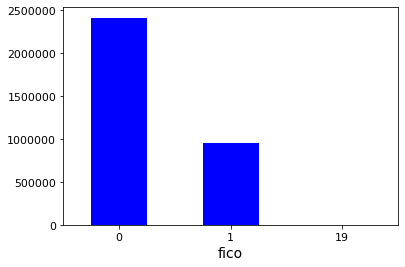

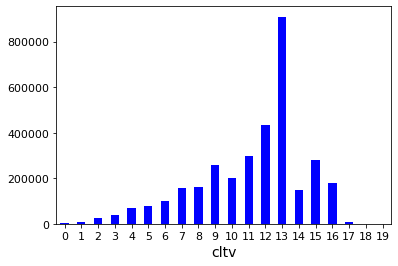

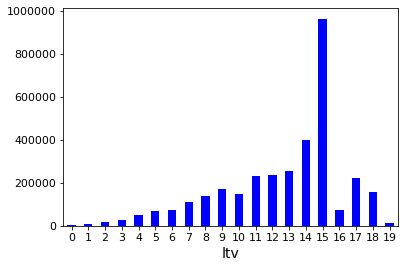

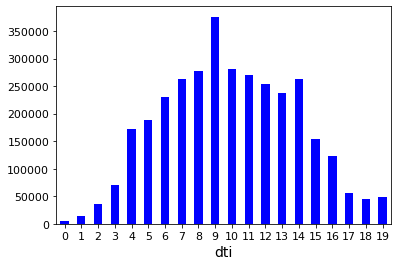

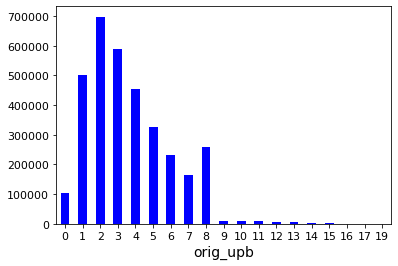

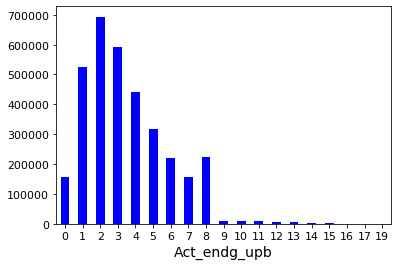

,fico,cltv,ltv,dti,orig_upb,Act_endg_upb
count,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00
mean,751.55,69.72,68.49,34.36,197440.11,185041.50
std,174.88,17.34,17.35,12.46,108618.11,108337.05
min,300.00,6.00,6.00,1.00,6000.00,0.00
25%,717.00,60.00,58.00,25.00,113000.00,103000.00
50%,760.00,75.00,74.00,34.00,175000.00,163000.00
90%,802.00,90.00,90.00,51.00,365000.00,349586.62
95%,808.00,94.00,91.00,55.00,416000.00,398323.93
98%,813.00,95.00,95.00,60.00,417000.00,414000.00
99%,816.00,95.00,95.00,63.00,470000.00,451000.00


In [54]:
# Clean 3: Remove outlines

# Cut each variable into bins of an equal distribution and see whether a monotonic trend emerges

num_list = ['fico','cltv','ltv','dti','orig_upb','Act_endg_upb']

for num in num_list:
    # cut x into 20 bins according to its value
    df.loc[:,'value_ranks']=pd.cut(df.loc[:,num], 20, labels = False)
    df.groupby(df.value_ranks).size().plot(kind='bar', color='blue')
    plot_format('',num,'')
    plt.show()

# Suppress the outliers for continuous values
df.loc[:,num_list].describe(percentiles=(0.25, 0.5, 0.9, 0.95, 0.98, 0.99))

In [55]:
# Cap the outlier. I choose 98 percentile for each continuous variable
# It also depends on variable behavior, i.e., FICO > 800 shows no behavioral difference, so we cap FICO at 800

df.loc[:,'fico']=np.where(df.loc[:,'fico'] > 800, 800, df.loc[:,'fico'])
df.loc[:,'cltv']=np.where(df['cltv'] > 95, 95, df.loc[:,'cltv'])
df.loc[:,'ltv']=np.where(df['ltv'] > 95, 95, df.loc[:,'ltv'])
df.loc[:,'dti']=np.where(df['dti'] > 60, 60, df.loc[:,'dti'])
df.loc[:,'orig_upb']=np.where(df.loc[:,'orig_upb'] > 417000, 417000, df.loc[:,'orig_upb'])
df.loc[:,'Act_endg_upb']=np.where(df.loc[:,'Act_endg_upb'] > 414000, 414000, df.loc[:,'Act_endg_upb'])


### Examine Character Variables

In [56]:
# Collapsing a variable means changing the scale of a variable:
# putting them in class intervals / assigning ranks to the observations. 

# Clean 4: Fix with missing values
df.loc[df.loc[:,'ppmt_pnlty'].isna(), 'ppmt_pnlty']='Y'
df.loc[df.loc[:,'flag_sc'].isna(), 'flag_sc']='N'

# Clean 2: Make derived variables - Create dummary variable
df.loc[:,'investment_property'] = np.where(df.loc[:,'occpy_sts'] == "I",1,0)
df.loc[:,'prepay_penalty']=np.where(df.loc[:,'ppmt_pnlty'] == "Y",1,0)
df.loc[:,'super_conforming']=np.where(df.loc[:,'flag_sc'] == "Y",1,0)
df.loc[:,'purchase_refinance']=np.where(df.loc[:,'loan_purpose'] == "P",1,0)

In [82]:
# Clean 5: Drop unneeded variable from the sample

drop_col = ['flag_fthb','mi_pct','occpy_sts','flag_sc','channel','ppmt_pnlty', 'prop_type', 'loan_purpose',
            'fico_band','other_debt_to_value','other_debt_to_this_loan_ratio','delq_sts','delq_sts_num',
            'Period']

df_vif = df.drop(drop_col, axis=1)

# Clean 6: VIF analysis for multicollinearity --> based on project 2
df_model = df_vif.drop(['orig_upb_log','ltv','Act_endg_upb'], axis=1)
df_model.describe()

,fico,cnt_units,cltv,dti,orig_upb,int_rt,orig_loan_term,cnt_borr,loan_age,CD_Zero_BAL,deli,mi_flag,value_ranks,investment_property,prepay_penalty,super_conforming,purchase_refinance
count,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,59199.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00,3365968.00
mean,747.61,1.03,69.71,34.31,195813.83,5.51,327.99,1.55,21.98,1.14,0.04,0.14,3.47,0.06,0.01,0.01,0.31
std,47.63,0.23,17.32,12.35,103836.61,0.73,67.72,0.50,14.87,0.95,0.19,0.35,2.31,0.24,0.11,0.09,0.46
min,300.00,1.00,6.00,1.00,6000.00,3.88,60.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,717.00,1.00,60.00,25.00,113000.00,4.88,360.00,1.00,9.00,1.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00
50%,760.00,1.00,75.00,34.00,175000.00,5.38,360.00,2.00,20.00,1.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00
75%,788.00,1.00,80.00,44.00,261000.00,6.00,360.00,2.00,33.00,1.00,0.00,0.00,5.00,0.00,0.00,0.00,1.00
max,800.00,4.00,95.00,60.00,417000.00,9.50,480.00,2.00,58.00,9.00,1.00,1.00,19.00,1.00,1.00,1.00,1.00


## Define Prepayment

In [83]:
# If the balance of a loan becomes zero, it suggests the loan has been voluntarily prepaid.
# We need to exclude 'bad' loans from out definition of voluntary prepayment. 

per['prepaid']=np.where(per['CD_Zero_BAL']==1.0, 1, 0)
loans_prepaid=per.groupby('id_loan')[['prepaid']].sum().reset_index()
loans_prepaid['prepaid']=np.where(loans_prepaid['prepaid'] > 0, 1, 0)

loans_prepaid['prepaid'].mean()

0.631781431276487

In [84]:
df_model = pd.merge(loans_prepaid, df_model, how='inner', on='id_loan')

df_model['voluntary_prepay']=np.where((df_model.deli==0) & (df_model.prepaid==1), 1, 0)
df_model = df_model.drop(['deli','prepaid','id_loan','CD_Zero_BAL'], axis=1)
df_model['voluntary_prepay'].mean()

0.48810327370907863

## Split the sample

In [85]:
# Split the sample by 60/40 to make a modeling sample and a validation sample

df_model['random_temp']=np.random.uniform(0, 1, len(df_model))
split_pct=0.4

samp_train = df_model.loc[df_model['random_temp'] > split_pct]
samp_test = df_model.loc[df_model['random_temp'] <= split_pct]
samp_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2020280 entries, 1 to 3365962
Data columns (total 17 columns):
fico                   int64
cnt_units              int64
cltv                   int64
dti                    int64
orig_upb               int64
int_rt                 float64
orig_loan_term         int64
cnt_borr               int64
loan_age               int64
mi_flag                int64
value_ranks            int64
investment_property    int64
prepay_penalty         int64
super_conforming       int64
purchase_refinance     int64
voluntary_prepay       int64
random_temp            float64
dtypes: float64(2), int64(15)
memory usage: 277.4 MB


## Logit Model

In [86]:
import statsmodels.api as sm
from statsmodels.tools import add_constant

samp_train = add_constant(samp_train)

y_train = samp_train['voluntary_prepay']
x_train = samp_train.drop(['voluntary_prepay','random_temp'],axis=1)

logitreg = sm.Logit(y_train,x_train)

result = logitreg.fit()
result.summary()


/Users/xuduo/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Optimization terminated successfully.
         Current function value: 0.602667
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       voluntary_prepay   No. Observations:              2020280
Model:                          Logit   Df Residuals:                  2020264
Method:                           MLE   Df Model:                           15
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:                  0.1302
Time:                        16:14:25   Log-Likelihood:            -1.2176e+06
converged:                       True   LL-Null:                   -1.3998e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.2851      0.038   -139.731      0.000      -5.359      -5.211
fico                    0.0065   3.67e-05    177.455      0.000       0.006       0.007
cnt_units              -0.2429      0.008    -32.070      0.000      -0.258      -0.228
cltv                   -0.0065      0.000    -60.091      0.000      -0.007      -0.006
dti                    -0.0084      0.000    -62.433      0.000      -0.009      -0.008
orig_upb             1.133e-05   5.68e-08    199.438      0.000    1.12e-05    1.14e-05
int_rt                  0.1908      0.003     70.958      0.000       0.186       0.196
orig_loan_term         -0.0003   2.51e-05    -13.776      0.000      -0.000      -0.000
cnt_borr                0.2780      0.003     86.646      0.000       0.272       0.284
loan_age               -0.0456      0.000   -401.205      0.000      -0.046      -0.045
mi_flag                -0.2083      0.005    -39.757      0.000      -0.219      -0.198
value_ranks            -0.3508      0.003   -133.270      0.000      -0.356      -0.346
investment_property    -0.5890      0.007    -81.206      0.000      -0.603      -0.575
prepay_penalty          0.4353      0.014     30.351      0.000       0.407       0.463
super_conforming        1.0430      0.021     49.619      0.000       1.002       1.084
purchase_refinance      0.1038      0.004     27.699      0.000       0.096       0.111
=======================================================================================
"""

In [87]:
coef = result.params.values
print(coef,'\n')

samp_train['rawscore'] = (x_train * coef).sum(axis = 1)
samp_train['default_score']=samp_train['rawscore'].apply(lambda x:1/(1+np.exp(-1*x)))

print(samp_train[['voluntary_prepay', 'default_score']].mean())

[-5.28506879e+00  6.51512522e-03 -2.42926364e-01 -6.54596266e-03
 -8.38051075e-03  1.13315650e-05  1.90826677e-01 -3.45915909e-04
  2.78038388e-01 -4.56271405e-02 -2.08278310e-01 -3.50846023e-01
 -5.88998458e-01  4.35330403e-01  1.04301083e+00  1.03809699e-01] 

voluntary_prepay   0.49
default_score      0.49
dtype: float64


            default_score  voluntary_prepay
dist_ranks                                 
0                    0.15              0.13
1                    0.25              0.24
2                    0.33              0.34
3                    0.40              0.41
4                    0.46              0.47
5                    0.52              0.53
6                    0.59              0.58
7                    0.65              0.64
8                    0.72              0.71
9                    0.82              0.82
AxesSubplot(0.125,0.125;0.775x0.755)


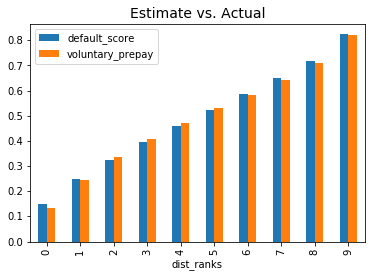

In [88]:
samp_train['dist_ranks']=pd.qcut(samp_train["default_score"], 10, labels=False, duplicates="drop")
rank_def_bad = samp_train[['default_score', 'voluntary_prepay']].groupby(samp_train['dist_ranks']).mean()
print(rank_def_bad)
print(rank_def_bad.plot(kind = 'bar'))

plt.title('Estimate vs. Actual', fontsize=14)
plt.show()


voluntary_prepay   0.49
default_score      0.49
dtype: float64
            default_score  voluntary_prepay
dist_ranks                                 
0                    0.15              0.13
1                    0.25              0.25
2                    0.32              0.33
3                    0.39              0.41
4                    0.46              0.47
5                    0.52              0.53
6                    0.59              0.59
7                    0.65              0.64
8                    0.72              0.71
9                    0.82              0.82
AxesSubplot(0.125,0.125;0.775x0.755)


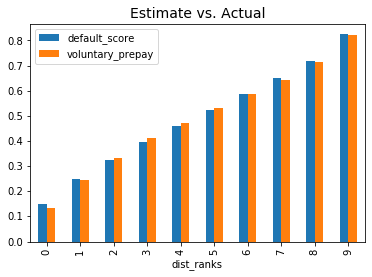

In [89]:
# Sample Validation

samp_test = add_constant(samp_test)

x_test = samp_test.drop(['voluntary_prepay','random_temp'],axis=1)

samp_test['rawscore'] = (x_test * coef).sum(axis=1)
samp_test['default_score']=samp_test['rawscore'].apply(lambda x:1/(1+np.exp(-1*x)))

print(samp_test[['voluntary_prepay', 'default_score']].mean())

samp_test['dist_ranks']=pd.qcut(samp_test["default_score"], 10, labels=False, duplicates="drop")
rank_def_bad = samp_test[['default_score', 'voluntary_prepay']].groupby(samp_test['dist_ranks']).mean()
print(rank_def_bad)
print(rank_def_bad.plot(kind = 'bar'))

plt.title('Estimate vs. Actual', fontsize=14)
plt.show()

In [90]:
# calculate KS statistics
samp_train['good']=1-samp_train['voluntary_prepay']
samp_test['good']=1-samp_test['voluntary_prepay']

In [91]:
# ks for training
samp_train['bucket'] = pd.qcut(samp_train.default_score, 10)
grouped = samp_train.groupby('bucket', as_index = False)

agg1 = grouped.min().default_score
agg2 = grouped.max().default_score
agg3 = grouped.count().default_score
agg4 = grouped.sum().voluntary_prepay
agg5 = grouped.sum().good

agg = pd.concat([agg1,agg2,agg3,agg4,agg5], axis=1)
agg.columns = ['min_scr','max_scr','total','bads','goods']

agg['bad_rate (%)'] = round(agg['bads'] / agg['total'] * 100,2)
agg['cum_bad_rate (%)'] = round(agg['bads'].cumsum() / agg['bads'].sum() * 100,2) # tpr
agg['cum_good_rate (%)'] = round(agg['goods'].cumsum() / agg['goods'].sum() * 100,2) # fpr
agg['ks'] = abs(agg['cum_bad_rate (%)'] - agg['cum_good_rate (%)'])
agg['max_ks'] = np.where(agg.ks == agg.ks.max(),"<-----","")

print("ks = ", round(max(agg.ks),2))
agg


ks =  33.84


,min_scr,max_scr,total,bads,goods,bad_rate (%),cum_bad_rate (%),cum_good_rate (%),ks,max_ks
0,0.01,0.21,202028,26938,175090,13.33,2.73,16.92,14.19,
1,0.21,0.29,202028,49174,152854,24.34,7.72,31.69,23.97,
2,0.29,0.36,202028,67807,134221,33.56,14.60,44.67,30.07,
3,0.36,0.43,202028,82530,119498,40.85,22.98,56.21,33.23,
4,0.43,0.49,202028,95507,106521,47.27,32.67,66.51,33.84,<-----
5,0.49,0.56,202028,106973,95055,52.95,43.52,75.69,32.17,
6,0.56,0.62,202028,118004,84024,58.41,55.50,83.81,28.31,
7,0.62,0.68,202028,129403,72625,64.05,68.63,90.83,22.20,
8,0.68,0.76,202028,143283,58745,70.92,83.16,96.51,13.35,
9,0.76,1.00,202028,165925,36103,82.13,100.00,100.00,0.00,


In [92]:
# ks for testing
samp_test['bucket'] = pd.qcut(samp_test.default_score, 10)
grouped = samp_test.groupby('bucket', as_index = False)
agg1 = grouped.min().default_score
agg2 = grouped.max().default_score
agg3 = grouped.count().default_score
agg4 = grouped.sum().voluntary_prepay
agg5 = grouped.sum().good

agg = pd.concat([agg1,agg2,agg3,agg4,agg5], axis=1)
agg.columns = ['min_scr','max_scr','total','bads','goods']

agg['bad_rate (%)'] = round(agg['bads'] / agg['total'] * 100,2)
agg['cum_bad_rate (%)'] = round(agg['bads'].cumsum() / agg['bads'].sum() * 100,2) # tpr
agg['cum_good_rate (%)'] = round(agg['goods'].cumsum() / agg['goods'].sum() * 100,2) # fpr
agg['ks'] = abs(agg['cum_bad_rate (%)'] - agg['cum_good_rate (%)'])
agg['max_ks'] = np.where(agg.ks == agg.ks.max(),"<-----","")

print("ks = ", round(max(agg.ks),2))
agg

# Meaning:
# If we choose 0.49 as cutoff (reject if the score lower than this value), we can reject 32.67% bad id correctly

ks =  33.89


,min_scr,max_scr,total,bads,goods,bad_rate (%),cum_bad_rate (%),cum_good_rate (%),ks,max_ks
0,0.01,0.21,134569,18145,116424,13.48,2.76,16.91,14.15,
1,0.21,0.29,134569,33119,101450,24.61,7.80,31.65,23.85,
2,0.29,0.36,134569,44946,89623,33.40,14.64,44.68,30.04,
3,0.36,0.43,134568,55143,79425,40.98,23.02,56.21,33.19,
4,0.43,0.49,134569,63388,71181,47.10,32.67,66.56,33.89,<-----
5,0.49,0.55,134569,71256,63313,52.95,43.50,75.76,32.26,
6,0.55,0.62,134568,78906,55662,58.64,55.51,83.84,28.33,
7,0.62,0.68,134569,86278,48291,64.11,68.63,90.86,22.23,
8,0.68,0.76,134569,95826,38743,71.21,83.21,96.49,13.28,
9,0.76,1.00,134569,110389,24180,82.03,100.00,100.00,0.00,


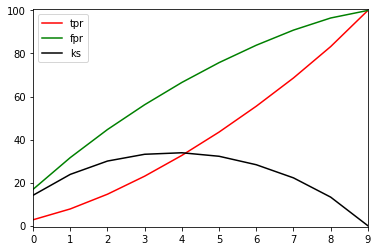

In [93]:
agg['cum_bad_rate (%)'].plot(label = 'tpr', c = 'red')
agg['cum_good_rate (%)'].plot(label = 'fpr', c = 'green')
agg['ks'].plot(label = 'ks', c = 'black')

plt.ylim([-0.5, 100.5])

plt.legend()

In [94]:
# The modeling exercise for this project has ended in the above section. 
# The following exercise is to compare logistic regression and decision tree only.

samp_train=df_model.loc[df_model['random_temp'] > split_pct]
samp_test=df_model.loc[df_model['random_temp'] <= split_pct]

x_train = samp_train.drop(['voluntary_prepay','random_temp'],axis=1)
y_train = samp_train['voluntary_prepay']

x_test = samp_test.drop(['voluntary_prepay','random_temp'],axis=1)
y_test = samp_test['voluntary_prepay']


### Logistic

In [95]:
from sklearn.linear_model import LogisticRegression

logreg=LogisticRegression(solver='lbfgs',max_iter=5000)
logreg.fit(x_train, y_train)

print("log_intercept:", logreg.intercept_)
print("log_coef:", logreg.coef_,"\n")

y_pred_proba = logreg.predict_proba(x_test)
y_pred = logreg.predict(x_test)

print("Predict Y by proability:\n", y_pred_proba)
print("Predict Y by class:\n",y_pred,'\n')

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))


log_intercept: [-8.23532457e-05]
log_coef: [[ 2.26126196e-03 -1.82815400e-04 -1.55868161e-02 -1.21783368e-02
   4.52710544e-06 -5.33449743e-04 -7.04751901e-04  1.96942977e-04
  -4.03635806e-02 -1.71964829e-04 -2.88962333e-04 -1.28211635e-04
   1.86030362e-05  7.19145356e-06  4.39435530e-05]] 

Predict Y by proability:
 [[0.37397022 0.62602978]
 [0.40272323 0.59727677]
 [0.44209184 0.55790816]
 ...
 [0.68324838 0.31675162]
 [0.64611077 0.35388923]
 [0.65528462 0.34471538]]
Predict Y by class:
 [1 1 1 ... 0 0 0] 

Accuracy of logistic regression classifier on test set: 0.65


In [100]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

# prepare the cross-validation procedure
cv = model_selection.KFold(n_splits=10, random_state=7)

# create model
model = LogisticRegression(solver='lbfgs',max_iter=50) # If error -> increase max_iter

# evaluate model
scores = model_selection.cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv)

# report performance
print("10-fold cross validation average accuracy: %.3f" % (scores.mean()))


10-fold cross validation average accuracy: 0.488


In [97]:
### Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_matrix,"\n")

print("Classification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[456570 231722]
 [233773 423623]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.66      0.66    688292
           1       0.65      0.64      0.65    657396

    accuracy                           0.65   1345688
   macro avg       0.65      0.65      0.65   1345688
weighted avg       0.65      0.65      0.65   1345688



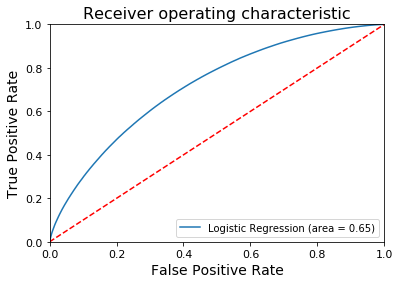

In [102]:
### ROC_AUC Score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])

plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plot_format('Receiver operating characteristic','False Positive Rate','True Positive Rate')

plt.legend(loc="lower right")
plt.show()


In [104]:
from sklearn import tree
from sklearn.metrics import accuracy_score

deci_tree = tree.DecisionTreeClassifier(criterion = "gini", # default -> or criterion = "entropy"
                                        random_state = 100,
                                        max_depth = 18,
                                        min_samples_leaf = 5) # min_sample required to be at a leaf node

deci_tree.fit(x_train, y_train)
y_pred = deci_tree.predict(x_test)
print ("Accuracy is {:.2f}".format(accuracy_score(y_test,y_pred)))


Accuracy is 0.78


In [105]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred)) 


              precision    recall  f1-score   support

           0       0.79      0.78      0.78    688292
           1       0.77      0.78      0.77    657396

    accuracy                           0.78   1345688
   macro avg       0.78      0.78      0.78   1345688
weighted avg       0.78      0.78      0.78   1345688

